In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [67]:
sns.set_style("whitegrid")

In [68]:
diseases_df = pd.read_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/df_final_processed.csv')
associations_df = pd.read_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/genes_diseases.csv')
genes_df = pd.read_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/genes_table_HUGO_final.csv')


### Gene Features


In [71]:
# --- Number of Unique Genes ---

# Assuming the main gene identifier is in a column named 'hgnc_id' or similar.
# Please adjust the column name if it's different in your file.
gene_id_column = 'id' # <-- IMPORTANT: Change this if your column name is different

if gene_id_column in genes_df.columns:
    num_unique_genes = genes_df[gene_id_column].nunique()
    print(f"Number of Unique Genes: {num_unique_genes}")
else:
    print(f"Error: Column '{gene_id_column}' not found. Please check the column name for gene identifiers.")

Number of Unique Genes: 3523


In [72]:
# --- Feature Completeness ---

# List of columns to check for completeness.
# Please adjust these names to match your DataFrame.
feature_columns_to_check = ['name', 'locus_type', 'gene_family'] # <-- Adjust these column names

print("Feature Completeness Analysis:")
for col in feature_columns_to_check:
    if col in genes_df.columns:
        # Calculate the number of non-empty entries
        non_empty_count = genes_df[col].count()
        # Calculate the total number of rows
        total_count = len(genes_df)
        # Calculate the percentage of completeness
        completeness_percentage = (non_empty_count / total_count) * 100
        print(f"- Column '{col}': {completeness_percentage:.2f}% complete ({non_empty_count}/{total_count} non-empty entries)")
    else:
        print(f"- Warning: Column '{col}' not found in the DataFrame.")

Feature Completeness Analysis:
- Column 'name': 100.00% complete (3523/3523 non-empty entries)
- Column 'locus_type': 100.00% complete (3523/3523 non-empty entries)
- Column 'gene_family': 66.28% complete (2335/3523 non-empty entries)


### Disease Features

In [122]:
disease_id_col = 'Disease ID'       # Column with the unique disease identifier
category_col = 'Disease Class' # Column with the disease category name

if disease_id_col in diseases_df.columns and category_col in diseases_df.columns:
    num_unique_diseases = diseases_df[disease_id_col].nunique()
    num_unique_categories = diseases_df[category_col].nunique()

    print(f"Number of Unique Diseases: {num_unique_diseases}")
    print(f"Number of Unique Disease Categories: {num_unique_categories}")

    # Check for missing values in the category column
    missing_categories = diseases_df[category_col].isnull().sum()
    print(f"\nNumber of diseases with missing categories: {missing_categories}")
else:
    print("Error: Please check the column names for 'disease_id_col' and 'category_col'.")


Number of Unique Diseases: 519
Number of Unique Disease Categories: 132

Number of diseases with missing categories: 0


/tmp/ipython-input-117-1227625904.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts[:10].values, y=category_counts[:10].index, palette='viridis')


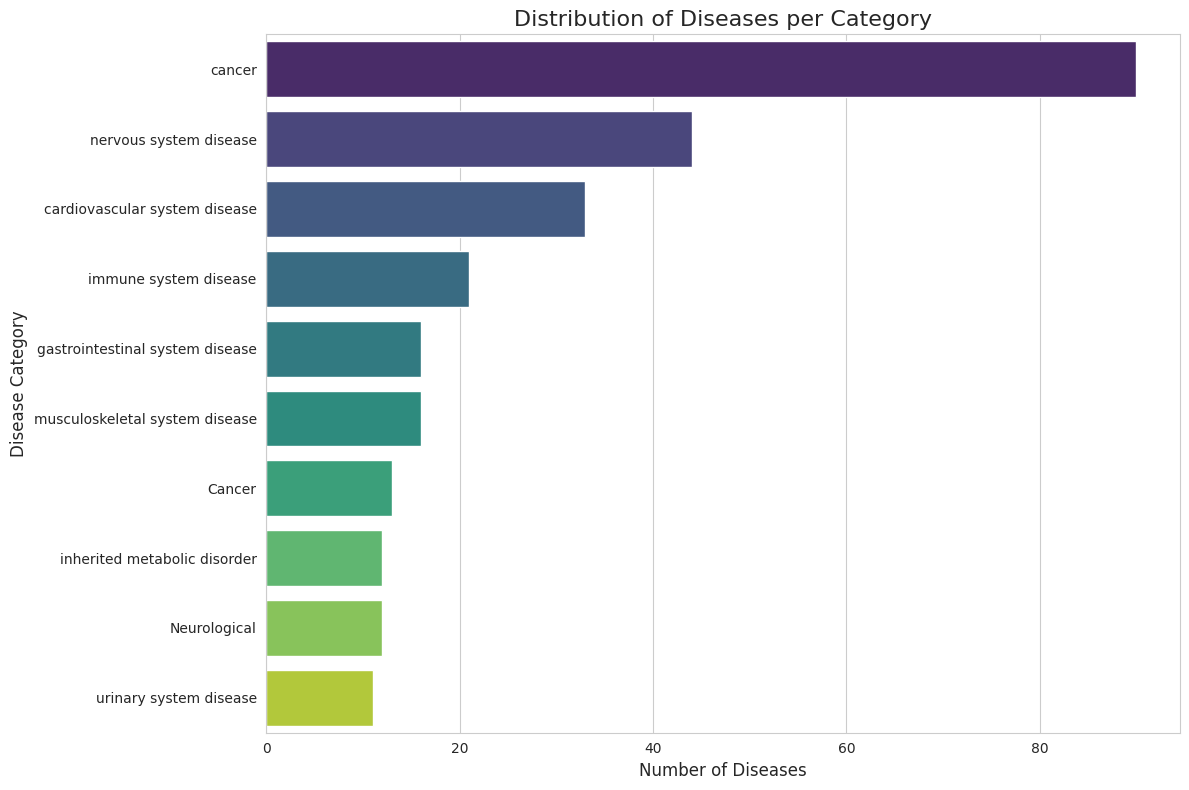


Top 10 most represented disease categories:
Disease Class
cancer                             90
nervous system disease             44
cardiovascular system disease      33
immune system disease              21
gastrointestinal system disease    16
musculoskeletal system disease     16
Cancer                             13
inherited metabolic disorder       12
Neurological                       12
urinary system disease             11
Name: count, dtype: int64


In [117]:
if category_col in diseases_df.columns:
    # Count the number of diseases in each category
    category_counts = diseases_df[category_col].value_counts()

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=category_counts[:10].values, y=category_counts[:10].index, palette='viridis')
    plt.title('Distribution of Diseases per Category', fontsize=16)
    plt.xlabel('Number of Diseases', fontsize=12)
    plt.ylabel('Disease Category', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 most represented disease categories:")
    print(category_counts.head(10))
else:
    print(f"Cannot plot distribution because column '{category_col}' was not found.")

### Graph analysis


In [97]:
try:
    # This file contains the edges of your graph
    print("Gene-disease associations loaded successfully!")

    source_col = '# Disease ID'
    target_col = 'Gene ID'

    # Drop rows with missing IDs to prevent errors
    associations_df.dropna(subset=[source_col, target_col], inplace=True)

    # Create an empty graph
    G = nx.Graph()

    # Iterate over the dataframe rows to add nodes and edges
    # This is the most robust way to ensure every node gets a 'type' attribute
    for index, row in associations_df.iterrows():
        disease_node = row[source_col]
        gene_node = row[target_col]

        # Add nodes with their type if they don't already exist
        # We use the rule that disease IDs contain 'C'
        if not G.has_node(disease_node):
            G.add_node(disease_node, type='disease')
        if not G.has_node(gene_node):
            G.add_node(gene_node, type='gene')

        # Add the edge
        G.add_edge(disease_node, gene_node)

    print("\nGraph built successfully!")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please check file paths.")
except KeyError as e:
    print(f"Error: A required column was not found: {e}. Please check your column names.")

Gene-disease associations loaded successfully!

Graph built successfully!


In [99]:
if 'G' in locals():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Calculate graph density
    if num_nodes > 1:
        density = nx.density(G)
    else:
        density = 0

    print("Basic Graph Statistics:")
    print(f"- Total Number of Nodes: {num_nodes}")
    print(f"- Total Number of Edges: {num_edges}")
    print(f"- Graph Density: {density:.6f}")
    if density < 0.01:
        print("  (Insight: The graph is very sparse, which is typical for biological networks.)")
else:
    print("Graph 'G' not created. Please run the previous cell first.")

Basic Graph Statistics:
- Total Number of Nodes: 4354
- Total Number of Edges: 8221
- Graph Density: 0.000868
  (Insight: The graph is very sparse, which is typical for biological networks.)


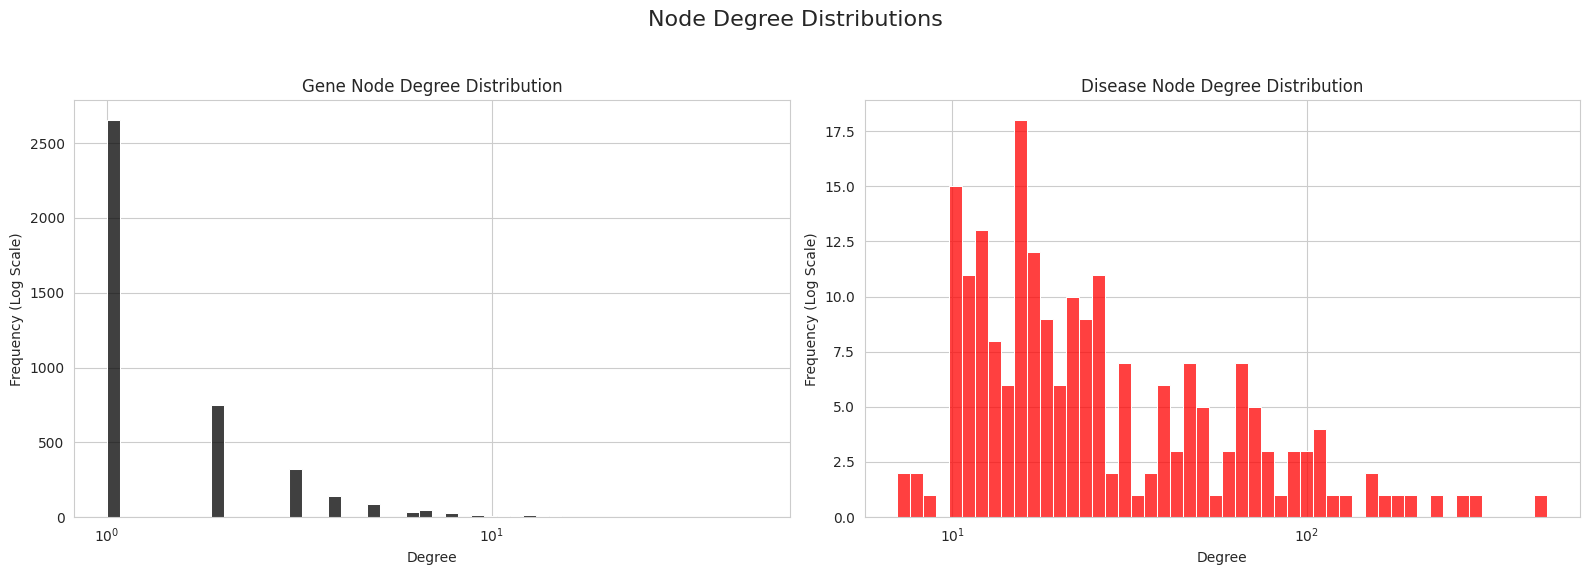


--- Gene Degree Statistics ---
Average Degree: 1.98
Max Degree: 49
Min Degree: 1

Most Connected Gene (Hub Gene ID: 7124):


,entrez_id,name,locus_group,locus_type,location,gene_family,gene_family_id,id,Start Chromossome,Start Chromossome Arm,Start Chromossome Loc,Start Chromossome SubLoc,End Chromossome Arm,End Chromossome Loc,End Chromossome SubLoc
2385,2315.0,melan-A,protein-coding gene,gene with protein product,9p24.1,NaN,NaN,7124,9.0,p,24.0,1.0,NaN,NaN,NaN



--- Disease Degree Statistics ---
Average Degree: 39.71
Max Degree: 478
Min Degree: 7

Most Connected Disease (Hub Disease ID: C0033578):


,Disease ID,Disease Name,Disease Class,Definitions,# Disease(DOID),main_system_affected
119,C0033578,Prostatic Neoplasms,cancer,Tumors or cancer of the PROSTATE.,NaN,Reproductive System


In [113]:
if 'G' in locals():
    # Separate nodes by type using a safe .get() method
    gene_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'gene']
    disease_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'disease']

    # Get degrees
    gene_degrees = [G.degree(n) for n in gene_nodes]
    disease_degrees = [G.degree(n) for n in disease_nodes]

    # Plotting the distributions
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Only plot if there are genes to plot
    if gene_degrees:
        sns.histplot(gene_degrees, bins=50, ax=axs[0], color='black', log_scale=True)
    axs[0].set_title('Gene Node Degree Distribution')
    axs[0].set_xlabel('Degree')
    axs[0].set_ylabel('Frequency (Log Scale)')

    # Only plot if there are diseases to plot
    if disease_degrees:
        sns.histplot(disease_degrees, bins=50, ax=axs[1], color='red', log_scale=True)
    axs[1].set_title('Disease Node Degree Distribution')
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Frequency (Log Scale)')

    plt.suptitle('Node Degree Distributions', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Degree statistics with checks for empty lists
    print("\n--- Gene Degree Statistics ---")
    if gene_degrees:
        print(f"Average Degree: {np.mean(gene_degrees):.2f}")
        max_gene_degree = np.max(gene_degrees)
        print(f"Max Degree: {max_gene_degree}")
        print(f"Min Degree: {np.min(gene_degrees)}")

        # Find and display the most connected gene
        max_degree_gene_id = gene_nodes[np.argmax(gene_degrees)]
        # Make sure genes_df is loaded from your first analysis script
        # IMPORTANT: Change 'id' to the actual column name in genes_df that matches the numeric gene IDs
        gene_info = genes_df[genes_df['id'] == max_degree_gene_id]
        print(f"\nMost Connected Gene (Hub Gene ID: {max_degree_gene_id}):")
        display(gene_info)
    else:
        print("No gene nodes with connections found in the graph.")

    print("\n--- Disease Degree Statistics ---")
    if disease_degrees:
        print(f"Average Degree: {np.mean(disease_degrees):.2f}")
        max_disease_degree = np.max(disease_degrees)
        print(f"Max Degree: {max_disease_degree}")
        print(f"Min Degree: {np.min(disease_degrees)}")

        # Find and display the most connected disease
        max_degree_disease_id = disease_nodes[np.argmax(disease_degrees)]
        disease_info = diseases_df[diseases_df['Disease ID'] == max_degree_disease_id]
        print(f"\nMost Connected Disease (Hub Disease ID: {max_degree_disease_id}):")
        display(disease_info)
    else:
        print("No disease nodes with connections found in the graph.")

else:
    print("Graph 'G' not created. Please run the previous cells first.")


In [93]:
if 'G' in locals():
    # --- Component Analysis ---
    connected_components = list(nx.connected_components(G))
    num_components = len(connected_components)

    print("Component Analysis:")
    print(f"- Number of Connected Components: {num_components}")

    if num_components > 0:
        largest_component = max(connected_components, key=len)
        print(f"- Size of Largest Component: {len(largest_component)} nodes")
        if num_components > 1:
            print("  (Insight: Multiple components mean the model cannot learn relationships between them.)")

    # --- Orphan Node Analysis ---
    # Orphan nodes are nodes with a degree of 0
    isolates = list(nx.isolates(G))
    orphan_genes = [n for n in isolates if G.nodes[n]['type'] == 'gene']
    orphan_diseases = [n for n in isolates if G.nodes[n]['type'] == 'disease']

    print("\nOrphan Node Analysis:")
    print(f"- Number of Orphan Genes (no connections): {len(orphan_genes)}")
    print(f"- Number of Orphan Diseases (no connections): {len(orphan_diseases)}")
    print("  (Insight: These nodes can only be represented by their own features, not by neighborhood information.)")

else:
    print("Graph 'G' not created. Please run the previous cells first.")

Component Analysis:
- Number of Connected Components: 1642
- Size of Largest Component: 4354 nodes
  (Insight: Multiple components mean the model cannot learn relationships between them.)

Orphan Node Analysis:
- Number of Orphan Genes (no connections): 1329
- Number of Orphan Diseases (no connections): 312
  (Insight: These nodes can only be represented by their own features, not by neighborhood information.)
